### --- Step 1: Setup and Imports ---


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks
import exclude.key
import os

# Hopsworks
HOPSWORKS_API_KEY = exclude.key.HOPSWORKS_API_KEY
FEATURE_GROUP_NAME = "bars_near_london_bridge"
FEATURE_GROUP_VERSION = 3
FEATURE_VIEW_VERSION = 4

# Connect to Hopsworks
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
fs = project.get_feature_store()
mr = project.get_model_registry()


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/25749
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


### --- Step 2: Load Data from the Feature group ---


In [48]:
# # Retrieve feature groups.
# fg = fs.get_feature_group(
#     name=FEATURE_GROUP_NAME, 
#     version=FEATURE_GROUP_VERSION,
# )

# # Select features for training datasets
# df = fg.read()
# df.head(5)

### --- Step 3: Process the Data ---

In [49]:
# # Load transformation functions from the feature store
# min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
# label_encoder = fs.get_transformation_function(name="label_encoder")

# # Define numerical and categorical features
# numerical_features = ["hour"]
# categorical_features = ["day"]

# # Map features to transformation functions
# transformation_functions = {}
# for feature in numerical_features:
#     transformation_functions[feature] = min_max_scaler
# for feature in categorical_features:
#     transformation_functions[feature] = label_encoder

# df.head(5)

### --- Step 4: Create the feature view ---

In [61]:
# query = fg.select_except(['busyness','venue_address','venue_name','last_updated','busyness'])

# feature_view = fs.get_or_create_feature_view(
#     name='busyness_feature_view',
#     version=FEATURE_VIEW_VERSION,
#     query=query,
#     labels=["busyness_numeric"],
#     transformation_functions=transformation_functions,
# )

# if the featureview is already created just retrieve it 
feature_view = fs.get_feature_view(name='busyness_feature_view', version=FEATURE_VIEW_VERSION)


### --- Step 5: Create the training dataset ---

In [62]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

X_train, X_val, X_test, y_train, y_val, y_test.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.48s) 
2024-06-10 10:41:17,887 WARNING: VersionWarning: Incremented version to `5`.



(      day      hour  popularity
 0       0  0.608696    0.438710
 3       1  0.260870    0.858065
 6       2  0.565217    1.000000
 8       2  1.000000    0.864516
 9       3  0.043478    0.564516
 ...   ...       ...         ...
 4023    2  1.000000    0.832258
 4024    0  0.913043    0.683871
 4025    2  0.652174    0.687097
 4027    6  0.913043    0.625806
 4031    3  0.565217    0.564516
 
 [2822 rows x 3 columns],
       day      hour  popularity
 4       3  0.652174    0.625806
 5       4  0.173913    0.764516
 11      2  0.652174    0.764516
 16      1  0.739130    0.858065
 19      3  0.043478    0.635484
 ...   ...       ...         ...
 4018    6  0.826087    0.858065
 4022    4  0.130435    0.625806
 4026    4  0.434783    0.625806
 4028    1  0.913043    0.564516
 4030    4  0.173913    0.651613
 
 [806 rows x 3 columns],
       day      hour  popularity
 1       0  0.304348    0.716129
 2       1  1.000000    0.625806
 7       4  0.913043    0.651613
 14      4  0.347826 

### --- Step 6: Train and evaluate the model ---

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsam

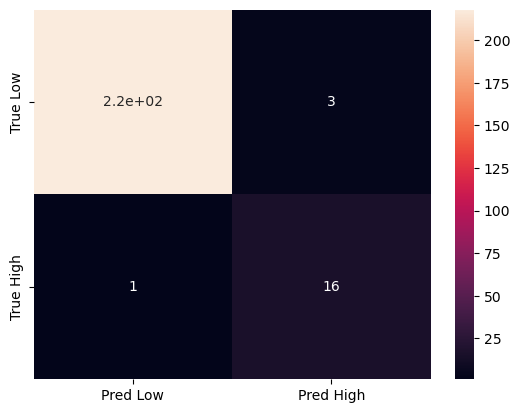

In [69]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an instance of the XGBClassifier
model = xgb.XGBClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Compute metrics
metrics = {"f1_score": f1_score(y_test, y_pred_test, average='macro')}
print(metrics)

# Confusion matrix
results = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
df_cm = pd.DataFrame(results, ['True Low', 'True High'], ['Pred Low', 'Pred High'])
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure().show()
fig = cm.get_figure()



### --- Step 7: Save the model ---

In [70]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

# Create a Schema for the input features
input_schema = Schema(X_train)

# Create a Schema for the output labels
output_schema = Schema(y_train)

# Create a ModelSchema using the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the ModelSchema to a dictionary representation
model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'day', 'type': 'Int32'},
   {'name': 'hour', 'type': 'float64'},
   {'name': 'popularity', 'type': 'float64'}]},
 'output_schema': {'columnar_schema': [{'name': 'busyness_numeric',
    'type': 'int64'}]}}

In [71]:
# Define the directory name for the model registry
model_dir = "busyness_model"

# Check if the directory exists, and create it if not
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model to a file within the model directory
joblib.dump(model, f"{model_dir}/xgboost_busyness.pkl")

# Save the confusion matrix plot to an image file within the model directory
fig.savefig(f"{model_dir}/confusion_matrix.png")


In [ ]:
# Get the model registry
mr = project.get_model_registry()

# Create a Python model in the model registry
fraud_model = mr.python.create_model(
    name="xgboost_busyness", 
    metrics=metrics,                     # Specify the metrics used to evaluate the model
    model_schema=model_schema,           # Provide the model schema
    description="Busyness Model",# Add a description for the model
)

# Save the model to the specified model directory
fraud_model.save(model_dir)
